In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Models & Evaluation
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn import linear_model
from sklearn.linear_model import ElasticNet
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn import metrics

<a id="4"></a>
# <p style="font-size:100%; text-align:left; color:#444444;">4- Models</p>

## Splitting dataset in train and test

In [2]:
def adjusted_r2_score(X, r2_score):
    return 1 - ( 1- r2_score ) * ( len(X) - 1 ) / ( len(X) - X.shape[1] - 1 )

In [3]:
hourly_data = pd.read_csv('../data/interim/hourly_data.csv')

In [23]:
hourly_data.shape

(7447, 14)

In [4]:
df = hourly_data.copy()
#df = hourlyDataWithoutOutliers.copy()
#df = transform_data.copy()
df = df.astype({'holiday': 'category', 'dayofweek': 'category', 'working_day': 'category', 'peak': 'category'})
predictors = ['rain','temp','wdsp','rhum','holiday','dayofweek','working_day','peak']

X = df[[c for c in df.columns if c in predictors]]
y = df.pop('count')
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
X_train.shape, X_test.shape

((5212, 8), (2235, 8))

## Split columns in categorical and numerical

In [5]:
num_vars = [c for c in df.select_dtypes(include=['number']).columns if c in predictors] # list comprehension to select only predictors features
cat_vars = df.select_dtypes(include=['category']).columns

## Preprocessing Pipelines

In [6]:
# Define categorical pipeline
cat_pipe = Pipeline([
    #('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('encoder', OneHotEncoder(handle_unknown='ignore', sparse=False))
])

# Define numerical pipeline
num_pipe = Pipeline([
    #('imputer', SimpleImputer(strategy='median')),
    #('scaler', StandardScaler())
    ('scaler', MinMaxScaler())
])

# Combine categorical and numerical pipelines
preprocessor = ColumnTransformer([
    ('cat', cat_pipe, cat_vars),
    ('num', num_pipe, num_vars)
])

## Feature Importance

In [7]:
# LightGBM model
params_lightgbm = {'n_estimators': 500, 
                   'boosting_type': 'dart', 
                   'max_depth': 5, 
                   'learning_rate': 0.01, 
                   'subsample': 0.7, 
                   'importance_type': 'gain'
                   }

# Fit a pipeline with transformers and an estimator to the training data
pipe_gbm = Pipeline([
    ('preprocessor', preprocessor),
    ('model', LGBMRegressor(**params_lightgbm))
])
pipe_gbm.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('cat',
                                                  Pipeline(steps=[('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  Index(['holiday', 'dayofweek', 'working_day', 'peak'], dtype='object')),
                                                 ('num',
                                                  Pipeline(steps=[('scaler',
                                                                   MinMaxScaler())]),
                                                  ['rain', 'temp', 'rhum',
                                                   'wdsp'])])),
                ('model',
                 LGBMRegressor(boosting_type='dart', importance_type='gain',
                               learning_ra

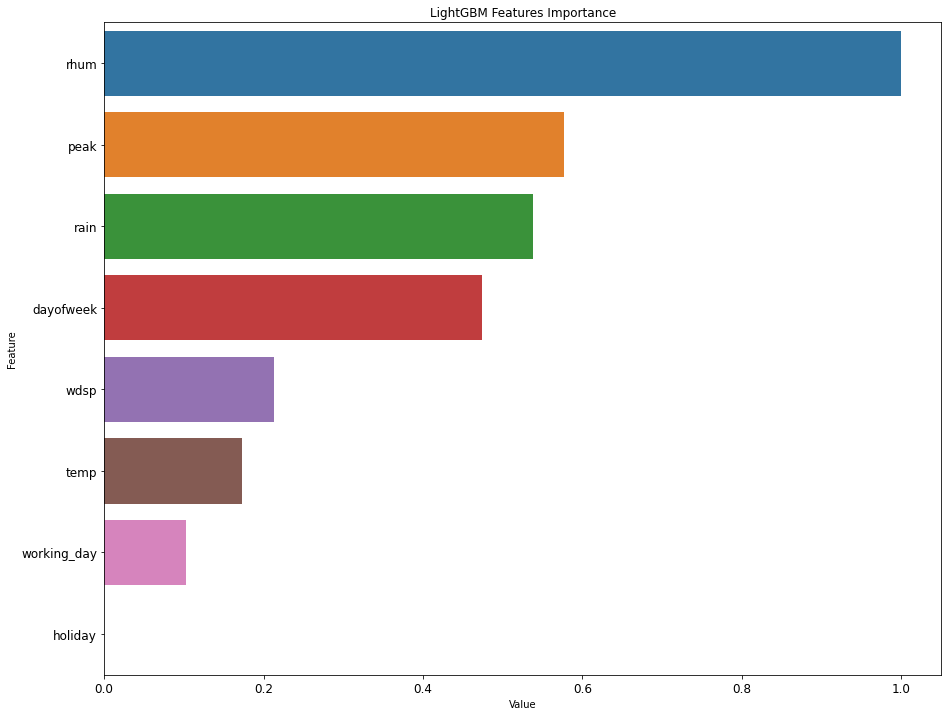

In [8]:
#Plotting features importance
feature_imp = pd.DataFrame(sorted(zip(pipe_gbm['model'].feature_importances_,X_train.columns)), columns=['Value','Feature'])
scaler_ft = MinMaxScaler()
feature_imp['Value'] = scaler_ft.fit_transform(feature_imp['Value'].values.reshape(-1,1))

fig = plt.figure(figsize=(15, 12))
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False))
plt.title('LightGBM Features Importance')
locs, labels = plt.xticks()
plt.tick_params(axis='both', which='major', labelsize=12)

plt.show()

## Linear Regression

In [9]:
pipe_linear_regression = Pipeline([
    ('preprocessor', preprocessor),
    ('model', LinearRegression())
])
pipe_linear_regression.fit(X_train, y_train)

# Predict training data
y_train_pred = pipe_linear_regression.predict(X_train)

# Predict test data
y_test_pred = pipe_linear_regression.predict(X_test)

print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_test_pred)))
print('R^2:', metrics.r2_score(y_test, y_test_pred))
print('Adjusted R^2:', adjusted_r2_score(X_test, metrics.r2_score(y_test, y_test_pred)))

Root Mean Squared Error: 3.0854346918199416
R^2: 0.23551986395364133
Adjusted R^2: 0.232772406142154


## Ridge Regression

[Ridge](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Ridge.html#sklearn.linear_model.Ridge) regression addresses some of the problems of Ordinary Least Squares by imposing a penalty on the size of the coefficients with l2 regularization.

In [10]:
# Fit a pipeline with transformers and an estimator to the training data
pipe_ridge = Pipeline([
    ('preprocessor', preprocessor),
    ('model', Ridge())
])
pipe_ridge.fit(X_train, y_train)

y_train_pred = pipe_ridge.predict(X_train)
y_test_pred = pipe_ridge.predict(X_test)

print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_test_pred)))
print('R^2:', metrics.r2_score(y_test, y_test_pred))
print('Adjusted R^2:', adjusted_r2_score(X_test, metrics.r2_score(y_test, y_test_pred)))

Root Mean Squared Error: 3.0836903487695606
R^2: 0.23638401360884953
Adjusted R^2: 0.2336396614565004


## Lasso Regression

The [Lasso](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Lasso.html#sklearn.linear_model.Lasso) is a linear model that estimates sparse coefficients with l1 regularization.

In [11]:
# Fit a pipeline with transformers and an estimator to the training data
pipe_lasso = Pipeline([
    ('preprocessor', preprocessor),
    ('model', linear_model.Lasso(alpha=0.1))
])
pipe_lasso.fit(X_train, y_train)
y_train_pred = pipe_lasso.predict(X_train)
y_test_pred = pipe_lasso.predict(X_test)

print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_test_pred)))
print('R^2:', metrics.r2_score(y_test, y_test_pred))
print('Adjusted R^2:', adjusted_r2_score(X_test, metrics.r2_score(y_test, y_test_pred)))

Root Mean Squared Error: 3.243241986691757
R^2: 0.1553200293133018
Adjusted R^2: 0.15228434208711417


## Elastic-Net

[Elastic-Net](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.ElasticNet.html#sklearn.linear_model.ElasticNet) is a linear regression model trained with both l1 and l2 -norm regularization of the coefficients.

In [12]:
# Fit a pipeline with transformers and an estimator to the training data
pipe_elastic = Pipeline([
    ('preprocessor', preprocessor),
    ('model', ElasticNet())
])
pipe_elastic.fit(X_train, y_train)
y_train_pred = pipe_elastic.predict(X_train)
y_test_pred = pipe_elastic.predict(X_test)

print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_test_pred)))
print('R^2:', metrics.r2_score(y_test, y_test_pred))
print('Adjusted R^2:', adjusted_r2_score(X_test, metrics.r2_score(y_test, y_test_pred)))

Root Mean Squared Error: 3.5289794874770415
R^2: -7.312522711178104e-05
Adjusted R^2: -0.0036672784175055817


## Random Forest Regressor

In [13]:
# random forest model
params_rf = {'n_estimators': 1000, 'max_depth': 15, 'random_state': 0, 'min_samples_split' : 5, 'n_jobs': -1}

# Fit a pipeline with transformers and an estimator to the training data
pipe_rf = Pipeline([
    ('preprocessor', preprocessor),
    ('model', RandomForestRegressor(**params_rf))
])
pipe_rf.fit(X_train, y_train)
y_train_pred = pipe_rf.predict(X_train)
y_test_pred = pipe_rf.predict(X_test)

print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_test_pred)))
print('R^2:', metrics.r2_score(y_test, y_test_pred))
print('Adjusted R^2:', adjusted_r2_score(X_test, metrics.r2_score(y_test, y_test_pred)))

Root Mean Squared Error: 3.080127557302435
R^2: 0.23814750641503568
Adjusted R^2: 0.23540949206252904


## GradientBoost

In [14]:
# GBM model
params_gbm = {'n_estimators': 150, 'max_depth': 5, 'random_state': 0, 'min_samples_leaf' : 10, 'learning_rate': 0.01, 'subsample': 0.7, 'loss': 'ls'}

# Fit a pipeline with transformers and an estimator to the training data
pipe_gbm = Pipeline([
    ('preprocessor', preprocessor),
    ('model', GradientBoostingRegressor(**params_gbm))
])
pipe_gbm.fit(X_train, y_train)
y_train_pred = pipe_gbm.predict(X_train)
y_test_pred = pipe_gbm.predict(X_test)

print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_test_pred)))
print('R^2:', metrics.r2_score(y_test, y_test_pred))
print('Adjusted R^2:', adjusted_r2_score(X_test, metrics.r2_score(y_test, y_test_pred)))

Root Mean Squared Error: 3.0804277126957555
R^2: 0.23799901563168713
Adjusted R^2: 0.23526046761958175


## LightGBM

In [15]:
# LightGBM model
params_lightgbm = {'n_estimators': 150, 'max_depth': 5, 'random_state': 0, 'learning_rate': 0.01, 'subsample': 0.7}

# Fit a pipeline with transformers and an estimator to the training data
pipe_gbm = Pipeline([
    ('preprocessor', preprocessor),
    ('model', LGBMRegressor(**params_lightgbm))
])
pipe_gbm.fit(X_train, y_train)
y_train_pred = pipe_gbm.predict(X_train)
y_test_pred = pipe_gbm.predict(X_test)

print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_test_pred)))
print('R^2:', metrics.r2_score(y_test, y_test_pred))
print('Adjusted R^2:', adjusted_r2_score(X_test, metrics.r2_score(y_test, y_test_pred)))

Root Mean Squared Error: 3.085894859933196
R^2: 0.23529181465086046
Adjusted R^2: 0.2325435372551763


## Catboost

In [21]:
# Catboost model

# Fit a pipeline with transformers and an estimator to the training data
pipe_catboost = Pipeline([
    ('preprocessor', preprocessor),
    ('model', CatBoostRegressor(verbose=1, n_estimators=100))
])
pipe_catboost.fit(X_train, y_train)
y_train_pred = pipe_catboost.predict(X_train)
y_test_pred = pipe_catboost.predict(X_test)

print('\n')
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_test_pred)))
print('R^2:', metrics.r2_score(y_test, y_test_pred))
print('Adjusted R^2:', adjusted_r2_score(X_test, metrics.r2_score(y_test, y_test_pred)))

Learning rate set to 0.30132
0:	learn: 3.2968173	total: 2.06ms	remaining: 204ms
1:	learn: 3.1921381	total: 4.36ms	remaining: 213ms
2:	learn: 3.1265527	total: 5.98ms	remaining: 193ms
3:	learn: 3.0899412	total: 8.92ms	remaining: 214ms
4:	learn: 3.0663301	total: 11ms	remaining: 210ms
5:	learn: 3.0510687	total: 13.2ms	remaining: 206ms
6:	learn: 3.0414590	total: 15.3ms	remaining: 203ms
7:	learn: 3.0330730	total: 18.3ms	remaining: 211ms
8:	learn: 3.0192702	total: 25.3ms	remaining: 256ms
9:	learn: 3.0125207	total: 27.7ms	remaining: 249ms
10:	learn: 3.0051403	total: 30.2ms	remaining: 245ms
11:	learn: 3.0025017	total: 33.4ms	remaining: 245ms
12:	learn: 2.9987186	total: 35.6ms	remaining: 239ms
13:	learn: 2.9957746	total: 37.4ms	remaining: 230ms
14:	learn: 2.9915947	total: 39.2ms	remaining: 222ms
15:	learn: 2.9807453	total: 41.1ms	remaining: 216ms
16:	learn: 2.9792740	total: 42.7ms	remaining: 209ms
17:	learn: 2.9754485	total: 44.4ms	remaining: 202ms
18:	learn: 2.9736591	total: 46.2ms	remaining: 1